In [1]:
import numpy as np
import pandas as pd

from drnb.io.pipeline import create_default_pipeline
from drnb.util import categorize


Data used by the PaCMAP authors to evaluate that method and several others 
([article](https://doi.org/10.1038/s42003-022-03628-x), 
[github repo](https://github.com/hyhuang00/scRNA-DR2020)). The names of the datasets are those used 
in the
[run_script.py](https://github.com/hyhuang00/scRNA-DR2020/blob/main/experiments/run_script.py) 
script at the github repo.

There are a couple of synthetic datasets, but most of the repo is interested in scRNA-seq data, so
we'll look at that first.

## scRNA-seq Datasets

There is a lot of data in the repo. The ones I was able to identify with datasets mentioned in the
paper are:

1. ercc (1015, 91), numerical labels, although I'm not sure what they are and they don't seem to 
  have been used in the paper to color the output.
2. monocyte (2612, 100), no labels.
3. duo4eq (3994, 100), integer labels.
4. duo8eq (3994, 100), integer labels.
5. kazer aka hiv (59286, 70), cell type labels.
6. stuart (30672, 70), cell type labels.
7. muraro (2282, 100), cell type labels.
8. kang (13999, 100), cell type labels.

Assuming you are interested in data sets of reasonable size with cell type labels, then the `kazer`,
`stuart` and `kang` datasets seem the most interesting, and those are the three that I will be
processing. `kazer` and `kang` are PBMC (peripheral blood mononuclear cells) datasets and `stuart`
is bone marrow cells. More details are in the paper.

In all cases, the data has been processed by [Seurat](https://satijalab.org/seurat/) or 
[scanpy](https://scanpy.readthedocs.io/en/stable/) with a typical scRNA-seq workflow of 
normalization, log transformation, a selection of highly variable genes in ~1000s was done, and then 
PCA down to no more than 100D. In practice, it looks like 70 dimensions is used. This is how the
data comes to us in the repo, so if you don't like how the preprocessing was done you are out of
luck and you'll need to be ok with how clusters were generated and gene activity assigned to them.

In [2]:
from io import BytesIO

import httpx

permalink_id = "6ebc7628447f97ab66e44933818c835d1be89f2c"


def read_np(url):
    req = httpx.get(url, timeout=10, follow_redirects=True)
    return np.load(BytesIO(req.content), allow_pickle=True)


def dr2020_url(name: str) -> str:
    return (
        f"https://github.com/hyhuang00/scRNA-DR2020/blob/{permalink_id}/data/{name}"
        + "?raw=true"
    )


def read_dr2020_data(name: str) -> np.ndarray:
    result = read_np(dr2020_url(name))
    return result


### ercc

Taken from [10x Genomics](https://www.10xgenomics.com/datasets).

In [3]:
ercc = read_dr2020_data("zheng_ercc_log_pca.npy")
ercc, ercc.shape

[23:03:04] INFO     HTTP Request: GET                                                ]8;id=491846;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=792810;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/zheng_ercc_log_pca.npy?raw=true                    
                    "HTTP/1.1 302 Found"                                                            

           INFO     HTTP Request: GET                                                ]8;id=133615;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=194013;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/zheng_ercc_log_pca.npy "HTTP/1.1 302                
                    Found"                                                                          

           INFO     HTTP Request: GET                                                ]8;id=155793;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=124369;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/zheng_ercc_log_pca.npy                   
                    "HTTP/1.1 200 OK"                                                               

(array([[ 7.09745040e+00, -3.75177293e+00,  2.84406024e+00, ...,
         -4.45187038e-02, -3.45198863e-02,  5.72270541e-03],
        [ 1.75928222e+00,  3.03900436e+00, -4.72712212e+00, ...,
          3.31507631e-03,  1.59327509e-02, -2.14731743e-03],
        [ 2.28635469e+00, -7.19247562e-02,  3.05617420e+00, ...,
         -4.99591598e-04, -4.55348847e-02, -1.07291121e-02],
        ...,
        [ 3.66076888e+00, -4.40207280e+00, -6.57716848e-01, ...,
         -8.71228617e-03,  7.08123309e-03, -3.41309213e-03],
        [ 4.50806470e+00,  6.16822567e-01, -5.97661380e+00, ...,
         -1.09600142e-01,  1.40795557e-01, -1.97941752e-03],
        [-1.08371981e+00, -1.29223282e-01,  4.20192685e+00, ...,
         -1.31728506e-02,  1.14280213e-02, -4.33042873e-03]]),
 (1015, 91))

In [4]:
ercc_labels = pd.read_csv(dr2020_url("ercc_label.csv"), header=0)
ercc_labels, ercc_labels.shape

(             x
 0     0.571429
 1     0.494505
 2     0.483516
 3     0.428571
 4     0.450549
 ...        ...
 1010  0.450549
 1011  0.472527
 1012  0.483516
 1013  0.505495
 1014  0.461538
 
 [1015 rows x 1 columns],
 (1015, 1))

### monocyte

Also downloaded from 10x Genomics.

In [5]:
monocyte = read_dr2020_data("zheng_monocyte_log_pca.npy")
monocyte, monocyte.shape

[23:03:05] INFO     HTTP Request: GET                                                ]8;id=128563;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=289538;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/zheng_monocyte_log_pca.npy?raw=true                
                     "HTTP/1.1 302 Found"                                                           

           INFO     HTTP Request: GET                                                ]8;id=789372;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=856286;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/zheng_monocyte_log_pca.npy "HTTP/1.1                
                    302 Found"                                                                      

           INFO     HTTP Request: GET                                                ]8;id=820348;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=305756;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/zheng_monocyte_log_pca.np                
                    y "HTTP/1.1 200 OK"                                                             

(array([[-17.61499862,   0.9860556 ,  -6.95554322, ...,  -0.31538644,
           1.98479704,   5.59104765],
        [-21.99655212,   8.67635955,   1.90315317, ...,  -0.81696591,
           1.26839263,   1.15141525],
        [-16.53292303,  -4.53028346,  -9.72801862, ...,  -6.40943367,
           3.32019375,  -4.03574972],
        ...,
        [ 90.39931558, -26.00330619,   1.62627292, ...,  16.54756219,
         -12.04685497,  13.32470591],
        [-24.59915774,   6.69298628,  -3.07256843, ...,   3.59516625,
          -3.73658028,   1.02894107],
        [  0.49166232, -10.88159655,  -1.00229575, ...,   2.26899708,
           2.76267441,  -0.12515488]]),
 (2612, 100))

### duo4eq

From the R Bioconductor package [DuoClustering2018](https://www.bioconductor.org/packages/release/data/experiment/html/DuoClustering2018.html).

In [6]:
duo4eq = read_dr2020_data("4eq_log_pca.npy")
duo4eq, duo4eq.shape

           INFO     HTTP Request: GET                                                ]8;id=257868;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=85383;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/4eq_log_pca.npy?raw=true "HTTP/1.1                 
                    302 Found"                                                                      

[23:03:06] INFO     HTTP Request: GET                                                ]8;id=189999;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=601512;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/4eq_log_pca.npy "HTTP/1.1 302 Found"                

           INFO     HTTP Request: GET                                                ]8;id=553091;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=269082;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/4eq_log_pca.npy "HTTP/1.1                
                    200 OK"                                                                         

(array([[-6.57364438,  3.91730611, -0.34138549, ...,  0.96116229,
          0.61568992, -0.31710044],
        [-8.73544915,  4.35021831,  0.92478115, ..., -2.18167639,
         -0.22110225,  0.51201019],
        [-1.30402802,  2.47924302, -3.56428628, ...,  2.05391468,
          0.7980184 ,  0.62571075],
        ...,
        [ 4.43016471, -1.2124964 ,  1.82110047, ..., -2.5523002 ,
          0.9301012 , -0.12728965],
        [-4.74352763,  5.45188221,  3.66093805, ..., -0.6067583 ,
         -1.74729126, -1.58547962],
        [ 0.28011265,  7.2852066 ,  0.55953195, ...,  0.30524204,
         -0.40552842,  0.77074477]]),
 (3994, 100))

In [7]:
duo4eq_labels = read_dr2020_data("4eq_labels.npy")
duo4eq_labels, duo4eq_labels.shape

           INFO     HTTP Request: GET                                                ]8;id=54622;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=968046;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/4eq_labels.npy?raw=true "HTTP/1.1                  
                    302 Found"                                                                      

           INFO     HTTP Request: GET                                                ]8;id=154578;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=617768;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/4eq_labels.npy "HTTP/1.1 302 Found"                 

[23:03:07] INFO     HTTP Request: GET                                                ]8;id=604915;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=8292;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/4eq_labels.npy "HTTP/1.1                 
                    200 OK"                                                                         

(array([0, 0, 0, ..., 3, 3, 3]), (3994,))

### duo8eq

Also from the R Bioconductor package [DuoClustering2018](https://www.bioconductor.org/packages/release/data/experiment/html/DuoClustering2018.html).

In [8]:
duo8eq = read_dr2020_data("8eq_log_pca.npy")
duo8eq, duo8eq.shape

           INFO     HTTP Request: GET                                                ]8;id=770964;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=242878;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/8eq_log_pca.npy?raw=true "HTTP/1.1                 
                    302 Found"                                                                      

[23:03:08] INFO     HTTP Request: GET                                                ]8;id=934908;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=962591;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/8eq_log_pca.npy "HTTP/1.1 302 Found"                

           INFO     HTTP Request: GET                                                ]8;id=932863;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=184678;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/8eq_log_pca.npy "HTTP/1.1                
                    200 OK"                                                                         

(array([[-6.57364438,  3.91730611, -0.34138549, ...,  0.96116229,
          0.61568992, -0.31710044],
        [-8.73544915,  4.35021831,  0.92478115, ..., -2.18167639,
         -0.22110225,  0.51201019],
        [-1.30402802,  2.47924302, -3.56428628, ...,  2.05391468,
          0.7980184 ,  0.62571075],
        ...,
        [ 4.43016471, -1.2124964 ,  1.82110047, ..., -2.5523002 ,
          0.9301012 , -0.12728965],
        [-4.74352763,  5.45188221,  3.66093805, ..., -0.6067583 ,
         -1.74729126, -1.58547962],
        [ 0.28011265,  7.2852066 ,  0.55953195, ...,  0.30524204,
         -0.40552842,  0.77074477]]),
 (3994, 100))

In [9]:
duo8eq_labels = read_dr2020_data("8eq_labels.npy")
duo8eq_labels, duo8eq_labels.shape

[23:03:09] INFO     HTTP Request: GET                                                ]8;id=27918;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=726311;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/8eq_labels.npy?raw=true "HTTP/1.1                  
                    302 Found"                                                                      

           INFO     HTTP Request: GET                                                ]8;id=802007;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=540375;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/8eq_labels.npy "HTTP/1.1 302 Found"                 

           INFO     HTTP Request: GET                                                ]8;id=650170;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=901352;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/8eq_labels.npy "HTTP/1.1                 
                    200 OK"                                                                         

(array([0, 0, 0, ..., 6, 6, 6]), (3994,))

### kazer

Integrated single-cell analysis of multicellular immune dynamics during hyperacute HIV-1 infection.
Kazer et al. [Nature Medicine, 2020](https://doi.org/10.1038/s41591-020-0799-2).

scRNA-seq data derived from peripheral blood mononuclear cells (PBMCs) from HIV-infected 
individuals. There are 7 cell types in this dataset, and the DR2020 authors note that UMAP separates
the dendritic cell (DCs) cluster into two highly-separated sub-clusters based on their subtypes,
myeloid DCs (mDCs) and plasmacytoid DCs (pDCs) subtypes. On the other hand t-SNE, Trimap and PaCMAP
succeed in keeping these clusters together.

In [10]:
kazer = read_dr2020_data("hiv_70.npy")
kazer, kazer.shape

[23:03:10] INFO     HTTP Request: GET                                                ]8;id=324455;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=341272;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/hiv_70.npy?raw=true "HTTP/1.1 302                  
                    Found"                                                                          

           INFO     HTTP Request: GET                                                ]8;id=605016;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=35543;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/hiv_70.npy "HTTP/1.1 302 Found"                     

[23:03:12] INFO     HTTP Request: GET                                                ]8;id=52393;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=419948;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/hiv_70.npy "HTTP/1.1 200                 
                    OK"                                                                             

(array([[ 6.00433347, -0.13738266,  8.43688439, ..., -0.76738882,
          1.38062374,  1.83763155],
        [ 6.43884931, -0.02109753,  3.46516186, ...,  0.2850873 ,
          1.07715473, -1.41805308],
        [-4.07427148, -0.28312573,  2.62858524, ...,  0.59179122,
         -0.45742083,  0.86017597],
        ...,
        [ 7.89794021, -1.98255701, -1.93715547, ..., -1.06461982,
          2.01307923, -1.69550275],
        [10.10448407,  1.96206582, -2.15796513, ..., -0.01503851,
          0.24503597,  0.34803023],
        [ 8.17993468, -4.74993093, -0.90974439, ...,  0.72029909,
         -1.20492375, -3.53379333]]),
 (59286, 70))

In [11]:
kazer_labels = read_dr2020_data("hiv_label.npy")
kazer_labels, kazer_labels.shape

[23:03:13] INFO     HTTP Request: GET                                                ]8;id=968448;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=5650;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/hiv_label.npy?raw=true "HTTP/1.1                   
                    302 Found"                                                                      

           INFO     HTTP Request: GET                                                ]8;id=156207;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=397950;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/hiv_label.npy "HTTP/1.1 302 Found"                  

           INFO     HTTP Request: GET                                                ]8;id=72095;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=614775;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/hiv_label.npy "HTTP/1.1                  
                    200 OK"                                                                         

(array(['B cell', 'B cell', 'B cell', ..., 'T cell', 'T cell', 'T cell'],
       dtype=object),
 (59286,))

In [12]:
np.unique(kazer_labels)

array(['B cell', 'CTLs', 'DCs', 'NK cell', 'T cell', 'monocyte',
       'plasmablast'], dtype=object)

In [13]:
kazer_target = pd.Series(
    kazer_labels,
    name="cell_type",
    dtype="category",
).to_frame()
kazer_target

,cell_type
0,B cell
1,B cell
2,B cell
3,B cell
4,B cell
...,...
59281,T cell
59282,T cell
59283,T cell
59284,T cell


The DR2020's legends for this data names the cell types slightly differently than what appears in 
the repo, so we will do some renaming, and also order them categorically in the order they appear 
in the legend in the paper so we get the same order in the legend in the figures below.

In [14]:
kazer_target["cell_type"] = kazer_target["cell_type"].map(
    {
        "T cell": "CD4 T cells",
        "monocyte": "monocytes",
        "plasmablast": "plasmablasts",
        "B cell": "B cells",
        "CTLs": "CD8 T cells",
        "NK cell": "NK cells",
        "DCs": "DCs",
    }
)
kazer_target["cell_type"] = kazer_target["cell_type"].cat.reorder_categories(
    [
        "CD4 T cells",
        "monocytes",
        "plasmablasts",
        "B cells",
        "CD8 T cells",
        "NK cells",
        "DCs",
    ]
)

We'll also match the colors used for the cell types.

In [15]:
import matplotlib.pyplot as plt

color_dict = {
    "CD4 T cells": 1,
    "monocytes": 2,
    "plasmablasts": 3,
    "B cells": 4,
    "CD8 T cells": 5,
    "NK cells": 6,
    "DCs": 7,
}

color_map = plt.get_cmap("RdYlGn_r", len(color_dict))

palette = dict()
for cell_type, idx in color_dict.items():
    palette[cell_type] = "#" + "".join(
        f"{intval:0>2x}".upper() for intval in color_map(idx - 1, bytes=True)[:3]
    )

palette = dict(cell_type=palette)
palette

{'cell_type': {'CD4 T cells': '#006837',
  'monocytes': '#4CB05C',
  'plasmablasts': '#B7E075',
  'B cells': '#FFFFBF',
  'CD8 T cells': '#FDBE6E',
  'NK cells': '#EA5839',
  'DCs': '#A50026'}}

In [34]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True, csv=True).run(
    "kazer",
    data=kazer,
    target=kazer_target,
    target_palette=palette,
    verbose=True,
    url="https://doi.org/10.1038/s42003-022-03628-x",
    tags=["scRNAseq", "lowdim"],
)

[23:08:54] INFO     Requesting one extra neighbor to account for self-neighbor       ]8;id=6628;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=66314;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#623\623]8;;\

           INFO     Initial data shape: (59286, 70)                                   ]8;id=446195;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=843619;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#83\83]8;;\

           INFO     Keeping all columns                                             ]8;id=119916;file:///home/james/dev/drnb3/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=72721;file:///home/james/dev/drnb3/src/drnb/preprocess.py#90\90]8;;\

           INFO     Data shape after filtering columns: (59286, 70)                  ]8;id=665965;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=536292;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#164\164]8;;\

           INFO     Removing rows with NAs                                           ]8;id=195841;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=972300;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#145\145]8;;\

           INFO     Data shape after filtering NAs: (59286, 70)                      ]8;id=93363;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=491897;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#156\156]8;;\

           INFO     Checked for duplicates: found 0                                  ]8;id=941641;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=492514;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#172\172]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}     ]8;id=867856;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=788884;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#187\187]8;;\

           INFO     Writing data for kazer                                           ]8;id=431175;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=472586;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#298\298]8;;\

[23:09:01] INFO     Processing target with initial shape (59286, 1)                  ]8;id=336235;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=778802;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#243\243]8;;\

           INFO     Keeping all columns                                             ]8;id=771280;file:///home/james/dev/drnb3/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=145254;file:///home/james/dev/drnb3/src/drnb/preprocess.py#90\90]8;;\

           INFO     Writing target for kazer                                         ]8;id=810878;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=911956;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#298\298]8;;\

           INFO     Writing pkl format to data/kazer-target-palette.pkl              ]8;id=20358;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=111809;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#461\461]8;;\

           INFO     Calculating nearest neighbors                                    ]8;id=270137;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=608171;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#317\317]8;;\

           INFO     Using 'faiss' to find nearest neighbors                           ]8;id=672874;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=473651;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#90\90]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and      ]8;id=357642;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=244489;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#103\103]8;;\
                    params: {}                                                                      

[23:09:05] INFO     Writing numpy format to                                          ]8;id=675394;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=112901;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/kazer.16.euclidean.exact.faiss.idx.npy                                       

[23:09:07] INFO     Writing csv format to nn/kazer.16.euclidean.exact.faiss.idx.csv  ]8;id=751302;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=369157;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:09:08] INFO     Writing numpy format to                                          ]8;id=719660;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=723455;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/kazer.16.euclidean.exact.faiss.dist.npy                                      

[23:09:10] INFO     Writing csv format to nn/kazer.16.euclidean.exact.faiss.dist.csv ]8;id=739134;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=146548;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:09:11] INFO     Writing numpy format to                                          ]8;id=566771;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=468888;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/kazer.51.euclidean.exact.faiss.idx.npy                                       

[23:09:18] INFO     Writing csv format to nn/kazer.51.euclidean.exact.faiss.idx.csv  ]8;id=103503;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=605171;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:09:22] INFO     Writing numpy format to                                          ]8;id=749775;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=876068;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/kazer.51.euclidean.exact.faiss.dist.npy                                      

[23:09:26] INFO     Writing csv format to nn/kazer.51.euclidean.exact.faiss.dist.csv ]8;id=47095;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=393902;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:09:30] INFO     Writing numpy format to                                          ]8;id=51838;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=346472;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/kazer.151.euclidean.exact.faiss.idx.npy                                      

[23:09:31] INFO     Writing csv format to nn/kazer.151.euclidean.exact.faiss.idx.csv ]8;id=263783;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=157728;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:09:39] INFO     Writing numpy format to                                          ]8;id=817369;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=708806;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/kazer.151.euclidean.exact.faiss.dist.npy                                     

           INFO     Writing csv format to                                            ]8;id=839465;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=575484;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\
                    nn/kazer.151.euclidean.exact.faiss.dist.csv                                     

[23:09:50] INFO     Calculating triplets                                             ]8;id=29895;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=770639;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#331\331]8;;\

           INFO     Writing csv format to triplets/kazer.5.1337.idx.csv              ]8;id=274607;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=480250;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:09:52] INFO     Writing csv format to triplets/kazer.5.1337.euclidean.csv        ]8;id=383317;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=640983;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:09:53] INFO     Writing numpy format to triplets/kazer.5.1337.idx.npy            ]8;id=226163;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=857554;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\

           INFO     Writing numpy format to triplets/kazer.5.1337.euclidean.npy      ]8;id=560667;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=822522;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\

           INFO     Writing pipeline result for kazer                                ]8;id=300973;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=84335;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#134\134]8;;\

/home/james/dev/drnb3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


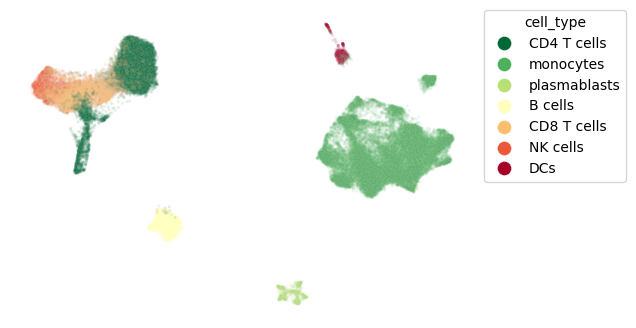

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.7517052929865399), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.5945382), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.05036939581014069), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.09229666363053673), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.1564443544850386), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [17]:
import drnb.embed.pipeline as pl

pl.standard_eval(method="umap", dataset="kazer")

### stuart

Comprehensive integration of single-cell data. Stuart et al.
[Cell, 2019](https://doi.org/10.1016/j.cell.2019.05.031)

In [18]:
stuart = read_dr2020_data("seurat_bmnc_rna_70.npy")
stuart, stuart.shape

[23:04:39] INFO     HTTP Request: GET                                                ]8;id=901760;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=184576;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/seurat_bmnc_rna_70.npy?raw=true                    
                    "HTTP/1.1 302 Found"                                                            

           INFO     HTTP Request: GET                                                ]8;id=723147;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=810844;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/seurat_bmnc_rna_70.npy "HTTP/1.1 302                
                    Found"                                                                          

           INFO     HTTP Request: GET                                                ]8;id=424993;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=228113;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/seurat_bmnc_rna_70.npy                   
                    "HTTP/1.1 200 OK"                                                               

(array([[-25.75181272,   1.80665468,   9.29553377, ...,   2.23871157,
           1.01727789,   0.28341085],
        [  3.69394604,   2.28493464,  -2.30133321, ...,   1.33965025,
           0.2826341 ,   0.08733732],
        [  5.75034849,   2.7062057 ,  -3.39919908, ...,   0.75111321,
          -0.59277897,  -1.079153  ],
        ...,
        [ -1.0746367 , -11.07778689,   1.07916351, ...,   2.82384294,
          -2.56411107,   0.06740622],
        [  3.17966421,   4.42122458,  -0.42049057, ...,  -0.57208344,
           1.4709507 ,  -0.03608233],
        [  3.70086985,   4.28908019,  -0.8800654 , ...,  -1.21298589,
           0.74786541,  -0.73100851]]),
 (30672, 70))

In [19]:
stuart_labels = read_dr2020_data("seurat_bmnc_label.npy")
stuart_labels, stuart_labels.shape

[23:04:40] INFO     HTTP Request: GET                                                ]8;id=991029;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=596914;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/seurat_bmnc_label.npy?raw=true                     
                    "HTTP/1.1 302 Found"                                                            

           INFO     HTTP Request: GET                                                ]8;id=990478;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=359809;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/seurat_bmnc_label.npy "HTTP/1.1 302                 
                    Found"                                                                          

           INFO     HTTP Request: GET                                                ]8;id=302198;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=458604;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/seurat_bmnc_label.npy                    
                    "HTTP/1.1 200 OK"                                                               

(array(['Prog_RBC', 'gdT', 'CD4 Naive', ..., 'CD16 Mono', 'CD4 Naive',
        'CD8 Naive'], dtype=object),
 (30672,))

In [20]:
stuart_target = pd.Series(
    stuart_labels,
    name="cell_type",
    dtype="category",
).to_frame()
stuart_target

,cell_type
0,Prog_RBC
1,gdT
2,CD4 Naive
3,CD4 Memory
4,CD14 Mono
...,...
30667,CD4 Memory
30668,CD4 Naive
30669,CD16 Mono
30670,CD4 Naive


In [35]:
data_result = create_default_pipeline(check_for_duplicates=True, csv=True).run(
    "stuart",
    data=stuart,
    target=stuart_target,
    verbose=True,
    url="https://doi.org/10.1038/s42003-022-03628-x",
    tags=["scRNAseq", "lowdim"],
)

           INFO     Requesting one extra neighbor to account for self-neighbor       ]8;id=926421;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=458688;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#623\623]8;;\

           INFO     Initial data shape: (30672, 70)                                   ]8;id=125051;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=168357;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#83\83]8;;\

           INFO     Keeping all columns                                             ]8;id=630935;file:///home/james/dev/drnb3/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=924900;file:///home/james/dev/drnb3/src/drnb/preprocess.py#90\90]8;;\

           INFO     Data shape after filtering columns: (30672, 70)                  ]8;id=1283;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=40585;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#164\164]8;;\

           INFO     Removing rows with NAs                                           ]8;id=306056;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=861385;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#145\145]8;;\

           INFO     Data shape after filtering NAs: (30672, 70)                      ]8;id=290311;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=547499;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#156\156]8;;\

           INFO     Checked for duplicates: found 0                                  ]8;id=761740;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=101620;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#172\172]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}     ]8;id=605900;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=3513;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#187\187]8;;\

           INFO     Writing data for stuart                                          ]8;id=982335;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=16537;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#298\298]8;;\

[23:09:57] INFO     Processing target with initial shape (30672, 1)                  ]8;id=282441;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=53035;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#243\243]8;;\

           INFO     Keeping all columns                                             ]8;id=846069;file:///home/james/dev/drnb3/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=672295;file:///home/james/dev/drnb3/src/drnb/preprocess.py#90\90]8;;\

           INFO     Writing target for stuart                                        ]8;id=540276;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=661748;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#298\298]8;;\

           INFO     Calculating nearest neighbors                                    ]8;id=199982;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=188919;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#317\317]8;;\

           INFO     Using 'faiss' to find nearest neighbors                           ]8;id=240602;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=482764;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#90\90]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and      ]8;id=189247;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=882217;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#103\103]8;;\
                    params: {}                                                                      

[23:09:59] INFO     Writing numpy format to                                          ]8;id=223837;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=527338;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/stuart.16.euclidean.exact.faiss.idx.npy                                      

[23:10:00] INFO     Writing csv format to nn/stuart.16.euclidean.exact.faiss.idx.csv ]8;id=905355;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=545333;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:10:01] INFO     Writing numpy format to                                          ]8;id=278316;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=182193;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/stuart.16.euclidean.exact.faiss.dist.npy                                     

           INFO     Writing csv format to                                            ]8;id=86592;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=12681;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\
                    nn/stuart.16.euclidean.exact.faiss.dist.csv                                     

[23:10:02] INFO     Writing numpy format to                                          ]8;id=915980;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=770522;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/stuart.51.euclidean.exact.faiss.idx.npy                                      

[23:10:05] INFO     Writing csv format to nn/stuart.51.euclidean.exact.faiss.idx.csv ]8;id=292565;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=459895;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:10:07] INFO     Writing numpy format to                                          ]8;id=894463;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=821332;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/stuart.51.euclidean.exact.faiss.dist.npy                                     

[23:10:09] INFO     Writing csv format to                                            ]8;id=214773;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=919618;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\
                    nn/stuart.51.euclidean.exact.faiss.dist.csv                                     

[23:10:11] INFO     Writing numpy format to                                          ]8;id=388356;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=906909;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/stuart.151.euclidean.exact.faiss.idx.npy                                     

           INFO     Writing csv format to                                            ]8;id=13438;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=320351;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\
                    nn/stuart.151.euclidean.exact.faiss.idx.csv                                     

[23:10:15] INFO     Writing numpy format to                                          ]8;id=128821;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=447717;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/stuart.151.euclidean.exact.faiss.dist.npy                                    

           INFO     Writing csv format to                                            ]8;id=198443;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=165420;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\
                    nn/stuart.151.euclidean.exact.faiss.dist.csv                                    

[23:10:21] INFO     Calculating triplets                                             ]8;id=746038;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=308726;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#331\331]8;;\

           INFO     Writing csv format to triplets/stuart.5.1337.idx.csv             ]8;id=42611;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=50869;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:10:22] INFO     Writing csv format to triplets/stuart.5.1337.euclidean.csv       ]8;id=389414;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=260501;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:10:23] INFO     Writing numpy format to triplets/stuart.5.1337.idx.npy           ]8;id=255000;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=749437;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\

           INFO     Writing numpy format to triplets/stuart.5.1337.euclidean.npy     ]8;id=294985;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=960705;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\

           INFO     Writing pipeline result for stuart                               ]8;id=883325;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=569797;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#134\134]8;;\

/home/james/dev/drnb3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


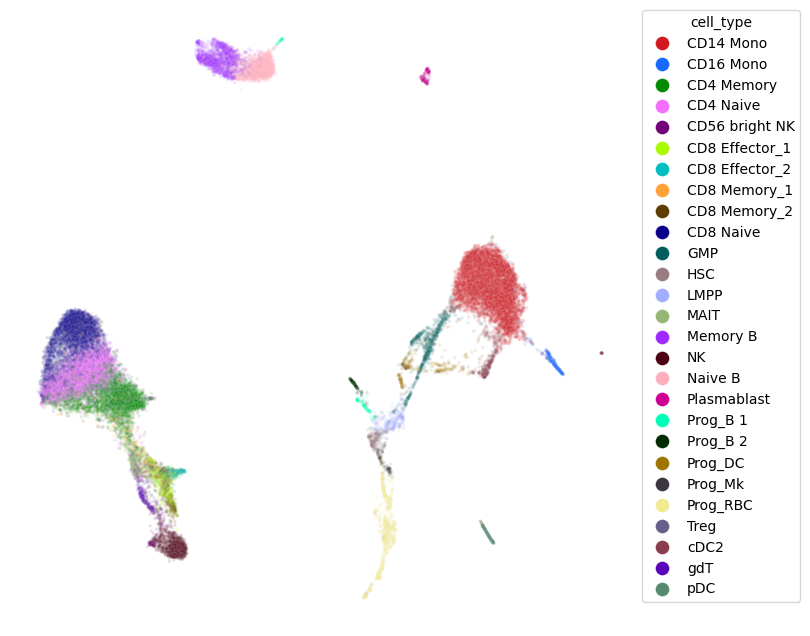

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.6708985393844549), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.29925218), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.07644757433489827), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.12701160667709965), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.20175708572422188), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [22]:
pl.standard_eval(
    method="umap", dataset="stuart", extra_plot={"legend": "force", "figsize": (8, 8)}
)

### muraro

A single-cell transcriptome atlas of the human pancreas. Muraro et al.
[Cell Systems, 2016](https://doi.org/10.1016/j.cels.2016.09.002)

In [23]:
muraro = pd.read_csv(
    f"https://github.com/hyhuang00/scRNA-DR2020/blob/{permalink_id}/data/Muraro_pca.csv?raw=true",
    index_col=0,
)
muraro

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100
D28.1_1,-5.964591,-2.222875,0.258055,-3.509606,-4.565023,3.012223,2.166402,-5.248680,0.999375,-0.498881,...,-0.272514,-1.062350,-0.609202,0.245455,0.265554,-0.801035,0.459874,-0.106717,0.569090,0.360376
D28.1_2,21.529526,22.603914,25.103457,17.857290,-33.264453,-59.601362,11.009635,-3.707651,0.639041,-1.387575,...,1.185023,0.471143,1.973157,-4.581496,-2.841973,5.414009,-3.478515,1.373988,2.897255,-0.587631
D28.1_3,-6.415044,-1.036834,-0.699896,1.557835,1.904706,-0.877249,-2.117881,4.361544,9.871168,0.081636,...,1.232358,-1.298850,1.704181,-1.157493,0.809831,-1.441625,0.170400,-1.828471,-1.819353,-2.209130
D28.1_4,-5.495318,-0.149050,-2.365808,8.195031,10.305321,-3.150147,4.175555,-5.613945,2.312193,-1.555932,...,1.543972,0.423428,-0.635414,-1.090983,1.080448,-2.836309,-1.477362,1.170691,2.352387,0.513717
D28.1_13,24.964946,-16.907725,-1.028643,12.228746,-4.170829,3.989286,-2.738070,2.111998,-2.146834,1.315070,...,0.931162,1.065032,-1.762058,-1.668728,-0.465756,-0.334842,-0.574936,0.374245,-2.093230,0.083179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D30.8_90,-6.090742,3.085694,-0.777793,-3.361087,-5.150156,3.220879,1.100121,-5.379829,0.395495,0.079315,...,-0.569977,2.761612,-2.178079,0.355901,-0.264963,-0.592072,-0.686670,0.472419,0.218842,-1.249685
D30.8_91,36.213127,48.144855,-7.272155,-4.190912,1.630142,2.820359,-7.479566,-2.568461,-1.790812,-0.020561,...,2.653373,-2.439167,7.963589,-0.627930,-0.728384,2.062570,-0.238976,5.156404,-1.857106,3.376119
D30.8_92,-4.671361,1.092902,-0.617564,-3.937495,-7.238269,1.821769,2.858166,-7.683161,1.834764,-0.372772,...,-1.373965,-2.428252,-1.110122,3.771834,0.422991,0.442192,-0.397107,0.829602,0.575682,-2.365758
D30.8_93,28.726417,-14.265048,-2.861160,14.069193,-6.667024,6.825309,-1.498308,-0.074474,-2.171852,1.001499,...,0.238613,0.074199,-0.866736,-0.394655,1.328030,2.011561,-0.089959,1.023212,2.258379,0.897189


In [24]:
muraro_labels = pd.read_csv(
    f"https://github.com/hyhuang00/scRNA-DR2020/blob/{permalink_id}/data/Muraro_labels.csv?raw=true",
    index_col=0,
)
muraro_labels

,celltype,nUMI
1,alpha,23231.849583
2,endothelial,31739.534893
3,delta,16752.271084
4,beta,33749.069894
5,duct,23343.634267
...,...,...
2278,alpha,15725.661696
2279,mesenchymal,45226.117313
2280,alpha,27990.424092
2281,duct,36310.966093


In [25]:
muraro = read_dr2020_data("muraro_log_pca.npy")
muraro_labels = read_dr2020_data("muraro_labels.npy")
muraro, muraro.shape, muraro_labels, muraro_labels.shape

[23:05:25] INFO     HTTP Request: GET                                                ]8;id=581402;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=990686;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/muraro_log_pca.npy?raw=true                        
                    "HTTP/1.1 302 Found"                                                            

           INFO     HTTP Request: GET                                                ]8;id=124714;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=994069;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/muraro_log_pca.npy "HTTP/1.1 302                    
                    Found"                                                                          

           INFO     HTTP Request: GET                                                ]8;id=740800;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=18190;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/muraro_log_pca.npy                       
                    "HTTP/1.1 200 OK"                                                               

[23:05:26] INFO     HTTP Request: GET                                                ]8;id=319478;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=629910;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/muraro_labels.npy?raw=true                         
                    "HTTP/1.1 302 Found"                                                            

           INFO     HTTP Request: GET                                                ]8;id=781042;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=337963;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/muraro_labels.npy "HTTP/1.1 302                     
                    Found"                                                                          

           INFO     HTTP Request: GET                                                ]8;id=380106;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=994954;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/muraro_labels.npy                        
                    "HTTP/1.1 200 OK"                                                               

(array([[ -8.61244845,  -0.14260658,  -1.17115708, ...,  -0.24337086,
           0.51804617,  -0.87234578],
        [ 25.44116109, -23.53216245,  18.35087535, ...,   2.030663  ,
           0.91238522,   1.44677607],
        [ -7.18052777,  -0.07591194,   0.80466816, ...,   0.18397381,
           0.28342915,  -0.13301833],
        ...,
        [ -8.61542766,  -1.45900807,  -0.75148963, ...,   0.62840734,
           0.50539162,  -0.29465563],
        [ 28.24035059,  18.15107925,  18.39824022, ...,   0.6342143 ,
           0.99368086,  -4.59920081],
        [ 40.77940014, -50.61058986,  -4.98973685, ...,   5.52248788,
          -2.80086367,   0.41845482]]),
 (2282, 100),
 array([1, 5, 3, ..., 1, 4, 7]),
 (2282,))

### kang

Multiplexed droplet single-cell RNA-sequencing using natural genetic variation. Kang et al.
[Nature Biotechnology, 2018](https://doi.org/10.1038/nbt.4042).

In [26]:
kang = read_dr2020_data("kang_log_pca.npy")
kang_labels = read_dr2020_data("kang_labels.npy")
kang_label_names = read_dr2020_data("kang_labels_names.npy")
kang, kang.shape, kang_labels, kang_labels.shape, kang_label_names

[23:05:27] INFO     HTTP Request: GET                                                ]8;id=652235;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=950457;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/kang_log_pca.npy?raw=true "HTTP/1.1                
                    302 Found"                                                                      

           INFO     HTTP Request: GET                                                ]8;id=54652;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=961987;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/kang_log_pca.npy "HTTP/1.1 302                      
                    Found"                                                                          

[23:05:28] INFO     HTTP Request: GET                                                ]8;id=940010;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=372326;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/kang_log_pca.npy                         
                    "HTTP/1.1 200 OK"                                                               

           INFO     HTTP Request: GET                                                ]8;id=902891;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=11108;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/kang_labels.npy?raw=true "HTTP/1.1                 
                    302 Found"                                                                      

           INFO     HTTP Request: GET                                                ]8;id=191637;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=720116;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/kang_labels.npy "HTTP/1.1 302 Found"                

[23:05:29] INFO     HTTP Request: GET                                                ]8;id=758053;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=691850;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/kang_labels.npy "HTTP/1.1                
                    200 OK"                                                                         

           INFO     HTTP Request: GET                                                ]8;id=112690;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=435222;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/kang_labels_names.npy?raw=true                     
                    "HTTP/1.1 302 Found"                                                            

           INFO     HTTP Request: GET                                                ]8;id=43378;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=561042;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/kang_labels_names.npy "HTTP/1.1 302                 
                    Found"                                                                          

[23:05:30] INFO     HTTP Request: GET                                                ]8;id=853839;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=512313;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/kang_labels_names.npy                    
                    "HTTP/1.1 200 OK"                                                               

(array([[11.73575877, -1.04614354, -0.19207239, ..., -0.41862305,
         -2.75586767, -1.1016474 ],
        [13.66566203,  1.72532164, -1.9862224 , ..., -1.83531429,
          2.06190655,  1.11409687],
        [11.62499179,  0.66431301, -1.40587835, ...,  0.5464301 ,
          0.17221211, -1.41710765],
        ...,
        [-5.19369435, -4.43776786,  1.12249285, ..., -1.21432757,
         -1.06063672,  2.02781197],
        [-8.43339793,  1.73422603, -1.61646538, ...,  0.05474123,
         -0.5318484 ,  0.33319442],
        [-9.63173539,  2.20534723, -1.39484309, ...,  1.42942994,
          0.06091892, -3.36774172]]),
 (13999, 100),
 array([0, 0, 0, ..., 4, 1, 1]),
 (13999,),
 array(['CD14 Mono', 'CD4 Naive T', 'CD4 Memory T', 'CD16 Mono', 'B',
        'CD8 T', 'NK', 'T activated', 'DC', 'B Activated', 'Mk', 'pDC',
        'Eryth'], dtype='<U12'))

In [27]:
kang_target = pd.DataFrame(
    dict(target=kang_labels, cell_type=kang_label_names[kang_labels])
)
categorize(kang_target, "cell_type")
kang_target

,target,cell_type
0,0,CD14 Mono
1,0,CD14 Mono
2,0,CD14 Mono
3,11,pDC
4,2,CD4 Memory T
...,...,...
13994,8,DC
13995,2,CD4 Memory T
13996,4,B
13997,1,CD4 Naive T


In [36]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True, csv=True).run(
    "kang",
    data=kang,
    target=kang_target,
    verbose=True,
    url="https://doi.org/10.1038/s42003-022-03628-x",
    tags=["scRNAseq", "lowdim"],
)

           INFO     Requesting one extra neighbor to account for self-neighbor       ]8;id=744994;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=554705;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#623\623]8;;\

           INFO     Initial data shape: (13999, 100)                                  ]8;id=977536;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=267736;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#83\83]8;;\

           INFO     Keeping all columns                                             ]8;id=69217;file:///home/james/dev/drnb3/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=587123;file:///home/james/dev/drnb3/src/drnb/preprocess.py#90\90]8;;\

           INFO     Data shape after filtering columns: (13999, 100)                 ]8;id=947872;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=660845;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#164\164]8;;\

           INFO     Removing rows with NAs                                           ]8;id=923320;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=613388;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#145\145]8;;\

           INFO     Data shape after filtering NAs: (13999, 100)                     ]8;id=152914;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=541734;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#156\156]8;;\

           INFO     Checked for duplicates: found 0                                  ]8;id=100055;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=384965;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#172\172]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}     ]8;id=541509;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=90508;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#187\187]8;;\

           INFO     Writing data for kang                                            ]8;id=525793;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=21610;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#298\298]8;;\

[23:10:25] INFO     Processing target with initial shape (13999, 2)                  ]8;id=929572;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=543053;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#243\243]8;;\

           INFO     Keeping all columns                                             ]8;id=578083;file:///home/james/dev/drnb3/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=968070;file:///home/james/dev/drnb3/src/drnb/preprocess.py#90\90]8;;\

           INFO     Writing target for kang                                          ]8;id=779780;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=357411;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#298\298]8;;\

           INFO     Calculating nearest neighbors                                    ]8;id=340683;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=818240;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#317\317]8;;\

           INFO     Using 'faiss' to find nearest neighbors                           ]8;id=576814;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=906473;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#90\90]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and      ]8;id=977317;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=434351;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#103\103]8;;\
                    params: {}                                                                      

[23:10:26] INFO     Writing numpy format to nn/kang.16.euclidean.exact.faiss.idx.npy ]8;id=718371;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=256349;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\

[23:10:27] INFO     Writing csv format to nn/kang.16.euclidean.exact.faiss.idx.csv   ]8;id=950325;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=747037;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

           INFO     Writing numpy format to                                          ]8;id=521489;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=357255;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/kang.16.euclidean.exact.faiss.dist.npy                                       

[23:10:28] INFO     Writing csv format to nn/kang.16.euclidean.exact.faiss.dist.csv  ]8;id=575367;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=959441;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

           INFO     Writing numpy format to nn/kang.51.euclidean.exact.faiss.idx.npy ]8;id=179379;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=14021;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\

[23:10:30] INFO     Writing csv format to nn/kang.51.euclidean.exact.faiss.idx.csv   ]8;id=716369;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=397507;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:10:31] INFO     Writing numpy format to                                          ]8;id=449202;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=189590;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/kang.51.euclidean.exact.faiss.dist.npy                                       

[23:10:32] INFO     Writing csv format to nn/kang.51.euclidean.exact.faiss.dist.csv  ]8;id=461925;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=185674;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:10:33] INFO     Writing numpy format to                                          ]8;id=426606;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=288788;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/kang.151.euclidean.exact.faiss.idx.npy                                       

           INFO     Writing csv format to nn/kang.151.euclidean.exact.faiss.idx.csv  ]8;id=99467;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=726676;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:10:35] INFO     Writing numpy format to                                          ]8;id=33080;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=44891;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/kang.151.euclidean.exact.faiss.dist.npy                                      

           INFO     Writing csv format to nn/kang.151.euclidean.exact.faiss.dist.csv ]8;id=165931;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=311209;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:10:38] INFO     Calculating triplets                                             ]8;id=988489;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=438994;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#331\331]8;;\

           INFO     Writing csv format to triplets/kang.5.1337.idx.csv               ]8;id=798158;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=327113;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

           INFO     Writing csv format to triplets/kang.5.1337.euclidean.csv         ]8;id=193912;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=621113;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[23:10:39] INFO     Writing numpy format to triplets/kang.5.1337.idx.npy             ]8;id=487181;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=193888;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\

           INFO     Writing numpy format to triplets/kang.5.1337.euclidean.npy       ]8;id=306133;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=130852;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\

           INFO     Writing pipeline result for kang                                 ]8;id=547449;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=686775;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#134\134]8;;\

/home/james/dev/drnb3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


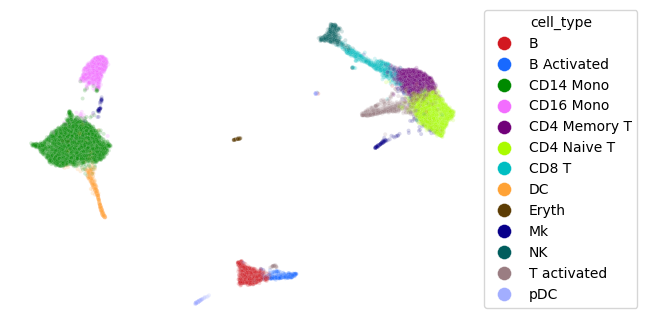

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.7095792556611188), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.6131896), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.08022001571540824), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.14398742767340525), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.2364502226349501), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [33]:
pl.standard_eval(method="umap", dataset="kang")

## Synthetic datasets

### hierarchical_three

The Three-Stage Hierarchical Gaussians dataset consisting of 125 micro clusters that are arranged 
into 5 meso and 25 macro clusters. This is referred to as the "Hierarchical" dataset in the paper, 
but the scripts in the repo refer to a separate set of files with that name, so to avoid confusion 
I stick with `hierarchical_three` as in the scripts (the files referred to as the `hierarchical` 
data aren't actually in the repo).

This dataset is covered in a lot more detail in the 
[synthetic-hierarchical notebook](https://github.com/jlmelville/drnb/blob/master/notebooks/data-pipeline/synthetic-hierarchical.ipynb).

In [29]:
hierarchical_three = read_np(
    f"https://github.com/hyhuang00/scRNA-DR2020/blob/{permalink_id}/data/hierarchical_threelayer_dataset.npy?raw=true"
)
hierarchical_three_labels = read_np(
    f"https://github.com/hyhuang00/scRNA-DR2020/blob/{permalink_id}/data/hierarchical_threelayer_label.npy?raw=true"
)
(
    hierarchical_three,
    hierarchical_three.shape,
    hierarchical_three_labels,
    hierarchical_three_labels.shape,
)

[23:05:45] INFO     HTTP Request: GET                                                ]8;id=984431;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=432884;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/hierarchical_threelayer_dataset.npy                
                    ?raw=true "HTTP/1.1 302 Found"                                                  

           INFO     HTTP Request: GET                                                ]8;id=233758;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=368407;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/hierarchical_threelayer_dataset.npy                 
                    "HTTP/1.1 302 Found"                                                            

[23:05:46] INFO     HTTP Request: GET                                                ]8;id=141487;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=556190;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/hierarchical_threelayer_d                
                    ataset.npy "HTTP/1.1 200 OK"                                                    

[23:05:47] INFO     HTTP Request: GET                                                ]8;id=129950;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=995529;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/hierarchical_threelayer_label.npy?r                
                    aw=true "HTTP/1.1 302 Found"                                                    

           INFO     HTTP Request: GET                                                ]8;id=376775;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=735452;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/hierarchical_threelayer_label.npy                   
                    "HTTP/1.1 302 Found"                                                            

[23:05:48] INFO     HTTP Request: GET                                                ]8;id=905992;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=22720;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/hierarchical_threelayer_l                
                    abel.npy "HTTP/1.1 200 OK"                                                      

(array([[   1.81535328,  -37.92864357, -110.44104389, ...,   86.39761456,
            6.89054946,   91.54234402],
        [   9.70159278,  -36.2866628 , -108.21577878, ...,   88.10015916,
           -1.99274459,   86.8882925 ],
        [   6.75312191,  -37.77401702, -112.41006185, ...,   86.25087924,
           -6.54116043,   88.0069918 ],
        ...,
        [ -72.46431938,   37.98013489,   29.00004613, ..., -131.87459958,
         -110.83952616,  103.04160037],
        [ -82.9046105 ,   34.10048348,   29.84212653, ..., -133.62037011,
         -103.02942305,  103.00641899],
        [ -73.28386826,   37.16551725,   31.54235544, ..., -128.58383712,
         -103.86861276,  109.62808573]]),
 (62500, 50),
 array([  0.,   0.,   0., ..., 124., 124., 124.]),
 (62500,))

### lineage

20 50D Gaussians (of 5000 points each) in a line. Referred to as "Gaussian linear" in the paper.
The labels indicate which gaussian the points are part of and increase as you go along the line.
The paper colors these with the `viridis` color scheme, which we also use by default with numeric
labels in the internal plotting of `drnb` so no special color map treatment is needed.

In [30]:
lineage = read_np(
    f"https://github.com/hyhuang00/scRNA-DR2020/blob/{permalink_id}/data/lineage_dataset.npy?raw=true"
)
lineage_labels = read_np(
    f"https://github.com/hyhuang00/scRNA-DR2020/blob/{permalink_id}/data/lineage_label.npy?raw=true"
)
lineage, lineage.shape, lineage_labels, lineage_labels.shape

           INFO     HTTP Request: GET                                                ]8;id=821686;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=367904;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/lineage_dataset.npy?raw=true                       
                    "HTTP/1.1 302 Found"                                                            

[23:05:49] INFO     HTTP Request: GET                                                ]8;id=670946;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=604728;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/lineage_dataset.npy "HTTP/1.1 302                   
                    Found"                                                                          

           INFO     HTTP Request: GET                                                ]8;id=457943;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=340628;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/lineage_dataset.npy                      
                    "HTTP/1.1 200 OK"                                                               

[23:05:50] INFO     HTTP Request: GET                                                ]8;id=224983;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=743812;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/blob/6ebc7628447f97ab6                
                    6e44933818c835d1be89f2c/data/lineage_label.npy?raw=true                         
                    "HTTP/1.1 302 Found"                                                            

           INFO     HTTP Request: GET                                                ]8;id=631262;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=429570;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/hyhuang00/scRNA-DR2020/raw/6ebc7628447f97ab66                
                    e44933818c835d1be89f2c/data/lineage_label.npy "HTTP/1.1 302                     
                    Found"                                                                          

           INFO     HTTP Request: GET                                                ]8;id=316621;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=217614;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/hyhuang00/scRNA-DR2020/6ebc762                
                    8447f97ab66e44933818c835d1be89f2c/data/lineage_label.npy                        
                    "HTTP/1.1 200 OK"                                                               

(array([[ 17.09352705, -21.41063249,  -2.62393043, ...,  -4.13696764,
          -8.36995831,  -4.47750394],
        [  7.66219179,  -2.06374933,  -1.93457165, ...,   5.21041865,
          11.27193896,   9.62918563],
        [  8.52888683,   1.59933765, -10.56491307, ...,   2.45680944,
           5.60487153,   0.49459228],
        ...,
        [375.33260862, 361.72037019, 367.98248111, ..., 380.8163951 ,
         388.21725432, 391.38440109],
        [377.75018804, 370.22472857, 379.22277086, ..., 389.9791645 ,
         399.37950481, 392.70167399],
        [372.56237504, 388.47652421, 410.80081218, ..., 374.93130799,
         364.07973155, 384.20107085]]),
 (10000, 50),
 array([ 0.,  0.,  0., ..., 19., 19., 19.]),
 (10000,))

In [31]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True, csv=True).run(
    "gaussian-linear",
    data=lineage,
    target=pd.Series(
        lineage_labels,
        name="location",
    ).to_frame(),
    verbose=True,
    tags=["synthetic", "lowdim"],
    url="https://doi.org/10.1038/s42003-022-03628-x",
)

           INFO     Requesting one extra neighbor to account for self-neighbor       ]8;id=807857;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=228976;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#623\623]8;;\

           INFO     Initial data shape: (10000, 50)                                   ]8;id=618879;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=105678;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#83\83]8;;\

           INFO     Keeping all columns                                             ]8;id=424938;file:///home/james/dev/drnb3/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=357453;file:///home/james/dev/drnb3/src/drnb/preprocess.py#90\90]8;;\

           INFO     Data shape after filtering columns: (10000, 50)                  ]8;id=655730;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=906138;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#164\164]8;;\

           INFO     Removing rows with NAs                                           ]8;id=421491;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=206005;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#145\145]8;;\

           INFO     Data shape after filtering NAs: (10000, 50)                      ]8;id=524709;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=483034;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#156\156]8;;\

           INFO     Checked for duplicates: found 0                                  ]8;id=616912;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=98898;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#172\172]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}     ]8;id=457948;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=295263;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#187\187]8;;\

           INFO     Writing data for gaussian-linear                                 ]8;id=124141;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=990794;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#298\298]8;;\

[23:05:51] INFO     Processing target with initial shape (10000, 1)                  ]8;id=728323;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=554691;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#243\243]8;;\

           INFO     Keeping all columns                                             ]8;id=330546;file:///home/james/dev/drnb3/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=883423;file:///home/james/dev/drnb3/src/drnb/preprocess.py#90\90]8;;\

           INFO     Writing target for gaussian-linear                               ]8;id=798080;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=525125;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#298\298]8;;\

           INFO     Calculating nearest neighbors                                    ]8;id=905690;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=791734;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#317\317]8;;\

           INFO     Using 'faiss' to find nearest neighbors                           ]8;id=634217;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=549230;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#90\90]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and      ]8;id=718396;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=832417;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#103\103]8;;\
                    params: {}                                                                      

[23:05:52] INFO     Writing numpy format to                                          ]8;id=261189;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=20741;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/gaussian-linear.16.euclidean.exact.faiss.idx.npy                             

           INFO     Writing csv format to                                            ]8;id=262888;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=557602;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\
                    nn/gaussian-linear.16.euclidean.exact.faiss.idx.csv                             

           INFO     Writing numpy format to                                          ]8;id=801340;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=846345;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/gaussian-linear.16.euclidean.exact.faiss.dist.npy                            

           INFO     Writing csv format to                                            ]8;id=766079;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=814584;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\
                    nn/gaussian-linear.16.euclidean.exact.faiss.dist.csv                            

[23:05:53] INFO     Writing numpy format to                                          ]8;id=164082;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=668561;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/gaussian-linear.51.euclidean.exact.faiss.idx.npy                             

[23:05:54] INFO     Writing csv format to                                            ]8;id=620458;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=818352;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\
                    nn/gaussian-linear.51.euclidean.exact.faiss.idx.csv                             

           INFO     Writing numpy format to                                          ]8;id=286328;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=23634;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/gaussian-linear.51.euclidean.exact.faiss.dist.npy                            

[23:05:55] INFO     Writing csv format to                                            ]8;id=593403;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=678167;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\
                    nn/gaussian-linear.51.euclidean.exact.faiss.dist.csv                            

[23:05:56] INFO     Writing numpy format to                                          ]8;id=66239;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=608255;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/gaussian-linear.151.euclidean.exact.faiss.idx.npy                            

           INFO     Writing csv format to                                            ]8;id=666773;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=260335;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\
                    nn/gaussian-linear.151.euclidean.exact.faiss.idx.csv                            

[23:05:57] INFO     Writing numpy format to                                          ]8;id=353707;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=740716;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/gaussian-linear.151.euclidean.exact.faiss.dist.npy                           

           INFO     Writing csv format to                                            ]8;id=701373;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=597157;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\
                    nn/gaussian-linear.151.euclidean.exact.faiss.dist.csv                           

[23:05:59] INFO     Calculating triplets                                             ]8;id=203391;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=329022;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#331\331]8;;\

           INFO     Writing csv format to triplets/gaussian-linear.5.1337.idx.csv    ]8;id=17169;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=838600;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

           INFO     Writing csv format to                                            ]8;id=8466;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=473520;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\
                    triplets/gaussian-linear.5.1337.euclidean.csv                                   

[23:06:00] INFO     Writing numpy format to triplets/gaussian-linear.5.1337.idx.npy  ]8;id=370302;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=449890;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\

           INFO     Writing numpy format to                                          ]8;id=200561;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=706235;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    triplets/gaussian-linear.5.1337.euclidean.npy                                   

           INFO     Writing pipeline result for gaussian-linear                      ]8;id=264651;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=784466;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#134\134]8;;\

Here's what it looks like if you run PCA on the data:

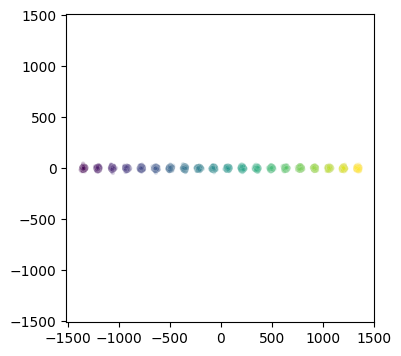

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.9956200000000001), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.999754), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.051886666666666664), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.146972), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.36933866666666665), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [32]:
import drnb.embed.pipeline as pl

pl.standard_eval(
    method="pca",
    dataset="gaussian-linear",
    extra_plot={"show_axes": True, "equal_axes": True},
)

With a default plot parameters, the results looks weirdly stretched in the y-axis, due to the big
difference in aspect ratio of the plot. Setting `"show_axes": True, "equal_axes": True` makes this
clearer.